# HMGCS2
[3-hydroxy-3-methylglutaryl-CoA synthase-2 deficiency (HMGCS2D)](https://omim.org/entry/605911) is caused by homozygous or compound heterozygous mutation in the HMGCS2 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


## HMGCS2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for HMGCS2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'HMGCS2'
mane_tx_id = 'NM_005518.4'
mane_protein_id = "NP_005509.1" # hydroxymethylglutaryl-CoA synthase, mitochondrial isoform 1 precursor
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release='0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 40/40 [00:06<00:00,  6.41 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Hypoglycemia
30,Metabolic acidosis
29,Dicarboxylic aciduria
25,Hepatomegaly
22,Elevated circulating alanine aminotransferase concentration
20,Elevated circulating aspartate aminotransferase concentration
16,Coma
16,Seizure
14,Vomiting
12,Elevated circulating acetylcarnitine concentration


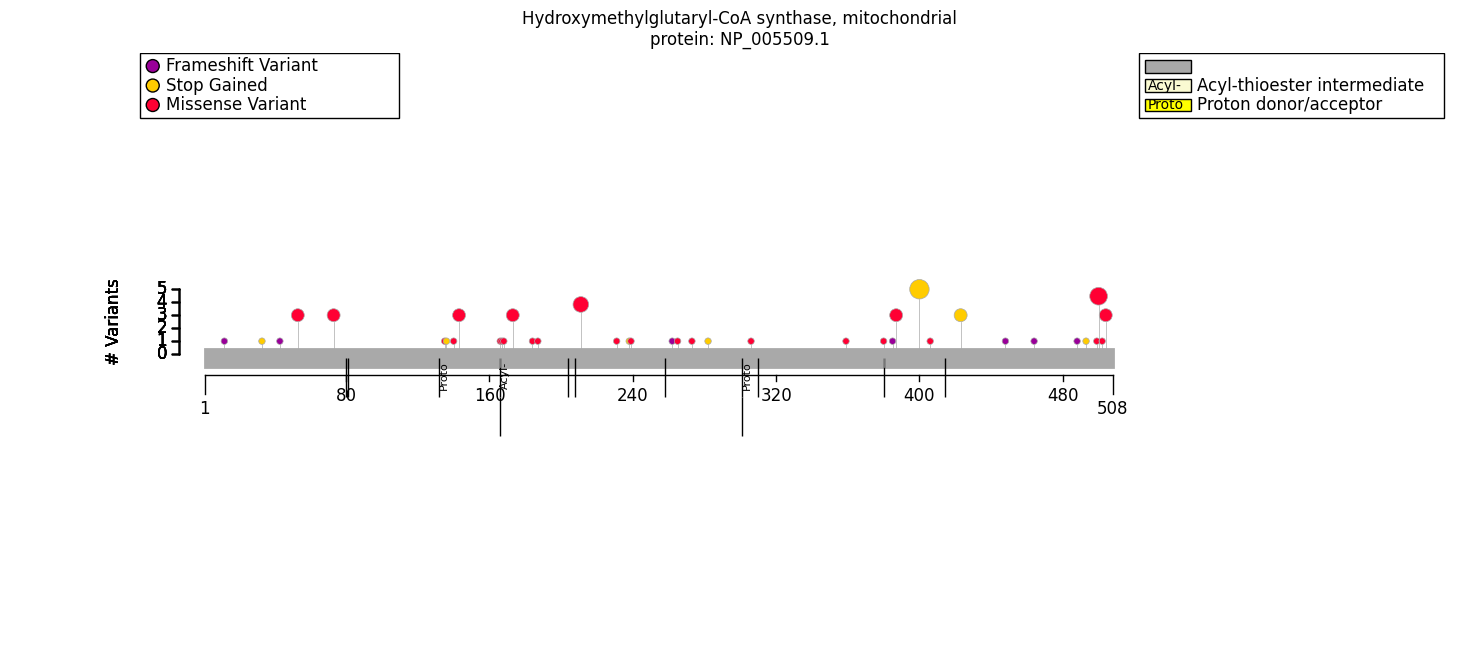

In [6]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

hmgcs2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
hmgcs2_fig.tight_layout()


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
6,SO:1000029_HGNC:5008_HMGCS2,SV involving HMGCS2 (p.?),,chromosomal deletion
5,1_119753373_119753373_C_A,c.1201G>T (p.Glu401Ter),7,stop gained
3,1_119759915_119759915_C_T,c.634G>A (p.Gly212Arg),3,missense
2,1_119764571_119764571_C_T,c.160G>A (p.Val54Met),2,missense
2,1_119750827_119750827_C_G,c.1502G>C (p.Arg501Pro),9,missense
2,1_119757272_119757272_C_T,c.1016+1G>A (-),-,splice donor
2,1_119750815_119750815_C_T,c.1514G>A (p.Arg505Gln),9,missense
2,1_119750827_119750827_C_T,c.1502G>A (p.Arg501Gln),9,missense
2,1_119764211_119764211_A_G,c.520T>C (p.Phe174Leu),2,missense
2,1_119755452_119755452_C_T,c.1162G>A (p.Gly388Arg),6,missense


# Genotype Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,3
"Skipping ""general"" level terms",42
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),76


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Hepatomegaly [HP:0002240],14/17 (82%),11/11 (100%),1.0,0.257937
Vomiting [HP:0002013],8/11 (73%),6/6 (100%),1.0,0.514706
Metabolic acidosis [HP:0001942],18/20 (90%),12/12 (100%),1.0,0.516129
Elevated circulating alanine aminotransferase concentration [HP:0031964],14/17 (82%),8/8 (100%),1.0,0.526957
Coma [HP:0001259],12/16 (75%),4/4 (100%),1.0,0.537668
Seizure [HP:0001250],12/17 (71%),4/7 (57%),1.0,0.646626
Reduced consciousness [HP:0004372],12/12 (100%),4/4 (100%),1.0,1.000000
Elevated circulating aspartate aminotransferase concentration [HP:0031956],13/15 (87%),7/7 (100%),1.0,1.000000
Abnormal circulating fatty-acid concentration [HP:0004359],14/14 (100%),10/10 (100%),1.0,1.000000
Abnormal liver morphology [HP:0410042],14/14 (100%),11/11 (100%),1.0,1.000000


In [11]:
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal import SurvivalAnalysis

disease_id = "OMIM:605911"  # HMG-CoA synthase-2 deficiency	
endpoint = disease_onset(disease_id=disease_id)

survival_statistic = LogRankTest()

survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)

missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)

print(f"survival analysis, disease onset, missense variant: p={missense_onset_result.pval}")

survival analysis, disease onset, missense variant: p=0.0379647192184346


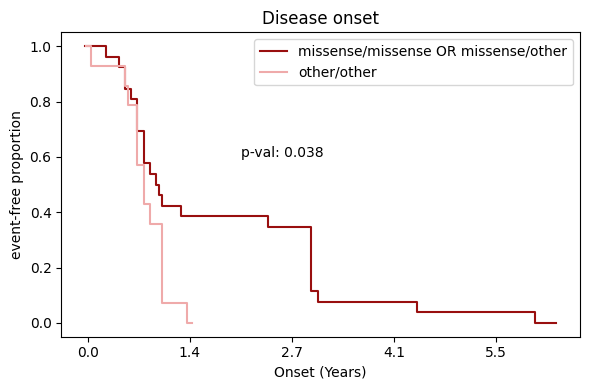

In [12]:
from matplotlib.ticker import FuncFormatter
from gpsea.model import Age

def days_to_years(x, pos):
    return f"{x / Age.DAYS_IN_YEAR:.1f}"

hmgcs2_onset_fig, ax = plt.subplots(figsize=(6, 4))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)
ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
ax.text(x=750, y=0.6, s=f"p-val: {missense_onset_result.pval:.3f}")

plt.tight_layout()

In [13]:
from gpsea.analysis.clf import sex_classifier


mf_fte_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_fte_result)

Sex,FEMALE,MALE,Corrected p values,p values
Metabolic acidosis [HP:0001942],12/12 (100%),7/9 (78%),1.0,0.171429
Dicarboxylic aciduria [HP:0003215],14/14 (100%),11/12 (92%),1.0,0.461538
Hepatomegaly [HP:0002240],11/12 (92%),9/11 (82%),1.0,0.590062
Seizure [HP:0001250],5/10 (50%),5/8 (62%),1.0,0.664061
Abnormal circulating lipid concentration [HP:0003119],10/10 (100%),10/10 (100%),1.0,1.000000
Elevated circulating aspartate aminotransferase concentration [HP:0031956],10/11 (91%),10/11 (91%),1.0,1.000000
Abnormal blood glucose concentration [HP:0011015],11/11 (100%),11/11 (100%),1.0,1.000000
Abnormal liver morphology [HP:0410042],11/11 (100%),9/9 (100%),1.0,1.000000
Visceromegaly [HP:0003271],11/11 (100%),9/9 (100%),1.0,1.000000
Elevated circulating alanine aminotransferase concentration [HP:0031964],11/12 (92%),11/13 (85%),1.0,1.000000


# Summary

In [14]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_fte_result,
    ), 
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
)

caption = "No previous publications with results on genotype-phenotype correlations in HMGCS2 were identified."

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    mono_results=m_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption,
)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [16]:
summarizer.process_latex(report=report, protein_fig=hmgcs2_fig, stats_fig=hmgcs2_onset_fig)

Figure saved to ../../supplement/img/HMGCS2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/HMGCS2_stats-draft.pdf
Output to ../../supplement/tex/HMGCS2_summary_draft.tex
